In [20]:
import rdkit
from rdkit import Chem
import numpy as np

def gen_oligomer_smiles(input_smiles, num_repeat_units=3,capped=False):
    #INPUTS:
    #input smiles: SMILES string of polymer of interest
    #num_repeat_units: number of repeat units of SMILES string to output
    #capped: False indicates that '*' character will be output to indicate terminating end of polymer
    
    #RETURNS:
    #capped_smiles: Output SMILES string of polymer with num_repeat_units repeating strings
    def FetchDum(smiles):
        m = Chem.MolFromSmiles(smiles)
        dummy_index = []
        if m is not None:
            for atom in m.GetAtoms():
                if atom.GetSymbol() == '*':
                    dummy_index.append(atom.GetIdx())
            for bond in m.GetBonds():
                if (bond.GetBeginAtom().GetSymbol() == '*'or bond.GetEndAtom().GetSymbol() == '*'):
                    bond_type = bond.GetBondType()
                    break
        print(dummy_index)
        return dummy_index, str(bond_type) #retruns teh index of *

    def FetchNeighborAtoms(smiles):
        near_neighbors=[]
        mol = Chem.MolFromSmiles(smiles)
        for i in range(mol.GetNumAtoms()):
            atom = mol.GetAtomWithIdx(i)
            for x in atom.GetNeighbors():
                if x.GetAtomicNum() == 0:
                    near_neighbors.append(i)
        print(near_neighbors)
        return(near_neighbors) #return idx of atoms next to *
    
    '''
    def FetchNeighborAtoms(smiles):
        near_neighbors=[]
        mol = Chem.MolFromSmiles(smiles)
        for i in range(mol.GetNumAtoms()):
            atom = mol.GetAtomWithIdx(i)
            if(0 in [x.GetAtomicNum() for x in atom.GetNeighbors()]):
                near_neighbors.append(i)
        return(near_neighbors) #return idx of neigbours '''
    

    def get_neighbors_from_mol(input_mol):
        neighbor_indices=[]
        for atom in input_mol.GetAtoms():
            for neighbor_atom in atom.GetNeighbors():
                if neighbor_atom.GetAtomicNum() == 0:
                    neighbor_indices.append(atom.GetIdx())
        return(np.array(neighbor_indices))
    
    """def get_neighbors_from_mol(input_mol):
    neighbor_indices=[]
    for atom in input_mol.GetAtoms():
        if (0 in [neighbor_atom.GetAtomicNum() for neighbor_atom in atom.GetNeighbors()]):
            neighbor_indices.append(atom.GetIdx())
    return(np.array(neighbor_indices))"""

    base_mol=Chem.MolFromSmiles(input_smiles) # the part where you will add the monomer
    monomer_mol=Chem.MolFromSmiles(input_smiles) #part that gets added on
    #prepare the monomer add-on part
    dum2=FetchDum(input_smiles)[0][0]
    atom2=FetchNeighborAtoms(input_smiles)[0]
    for neighbor in base_mol.GetAtomWithIdx(dum2).GetNeighbors():
        bond_type=base_mol.GetBondBetweenAtoms(dum2,neighbor.GetIdx())
        repeat_bond_type=str(bond_type.GetBondType())
    
    edit_m2 = Chem.EditableMol(monomer_mol)
    edit_m2.RemoveAtom(dum2)
    edit_m2_mol = edit_m2.GetMol()
            
    for iteration in range(num_repeat_units-1):
        base_smiles=Chem.MolToSmiles(base_mol)
        dummy_indices=np.where(np.array([atom.GetAtomicNum() for atom in base_mol.GetAtoms()])==0)[0]
        dum1=int(dummy_indices[1])
        
        neighbor_atoms=get_neighbors_from_mol(base_mol)
        atom1=int(neighbor_atoms[1])

        edit_m1 = Chem.EditableMol(base_mol)
        edit_m1.RemoveAtom(dum1)
        
        edit_m1_mol = edit_m1.GetMol()
        if dum1 < atom1:
            first_atom = atom1 - 1
        else:
            first_atom = atom1
        if dum2 < atom2:
            second_atom = atom2  +edit_m1_mol.GetNumAtoms()-1
        else:
            second_atom = atom2 + edit_m1_mol.GetNumAtoms()
        combo = Chem.CombineMols(edit_m1_mol, edit_m2_mol)
        edcombo = Chem.EditableMol(combo)
        if(repeat_bond_type=='SINGLE'):
            edcombo.AddBond(first_atom, second_atom, order=Chem.rdchem.BondType.SINGLE)
        elif(repeat_bond_type=='DOUBLE'):
            edcombo.AddBond(first_atom, second_atom, order=Chem.rdchem.BondType.DOUBLE)
        elif(repeat_bond_type=='TRIPLE'):
            edcombo.AddBond(first_atom, second_atom, order=Chem.rdchem.BondType.TRIPLE)
        elif(repeat_bond_type=='AROMATIC'):
            edcombo.AddBond(first_atom, second_atom, order=Chem.rdchem.BondType.AROMATIC)
        combo_mol = edcombo.GetMol()
        base_mol=combo_mol
        combo_smiles=Chem.MolToSmiles(combo_mol)
    if(capped):
        dummy_indices=np.where(np.array([atom.GetAtomicNum() for atom in combo_mol.GetAtoms()])==0)[0]
        final_ed_mol=Chem.EditableMol(combo_mol)
        #Remove *'s by replacing with H atoms
        final_ed_mol.ReplaceAtom(int(dummy_indices[1]),Chem.Atom('H'))
        final_ed_mol.ReplaceAtom(int(dummy_indices[0]),Chem.Atom('H'))
        final_out_mol=final_ed_mol.GetMol()
        final_out_mol=Chem.RemoveHs(final_out_mol)
        capped_smiles=Chem.MolToSmiles(final_out_mol)
    else:
        capped_smiles=combo_smiles
    return(capped_smiles)

[0, 7]
[1, 6]
Oligomer SMILES is: *CCC(F)(F)C(F)(F)CCC(F)(F)C(F)(F)CCC(F)(F)C(*)(F)F


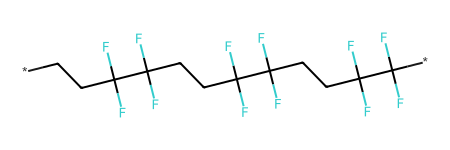

In [21]:
polymer_smiles=gen_oligomer_smiles('[*]CCC(F)(F)C([*])(F)F',num_repeat_units=3)
print('Oligomer SMILES is: ' + polymer_smiles)
Chem.MolFromSmiles(polymer_smiles)